In [1]:
from dataset import *
#from models import *
import tensorflow as tf
from utils.input import *

2023-05-23 22:58:31.255995: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 22:58:31.305251: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-05-23 22:58:31.305293: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-05-23 22:58:31.305317: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-23 22:58:31.314004: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 22:58:31.314728: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
data = DataLoader(path='DATA/speech_commands_v0.02')

In [3]:
commands = data.get_commands()
commands

array(['yes', 'off', 'five', 'eight', 'nine', 'six', 'up', 'no', 'two',
       'tree', 'follow', 'three', 'backward', 'down', 'on', 'right',
       'one', 'visual', 'happy', 'sheila', 'dog', 'zero', 'wow', 'bed',
       'house', 'cat', 'stop', 'marvin', 'learn', 'four', 'left',
       'forward', 'seven', 'go', 'bird'], dtype='<U19')

In [4]:
filenames = data.get_filenames()

In [5]:
train_files, val_files, test_files = data.split_data(filenames)

In [6]:
train_waveforms = data.get_waveform_ds(train_files)

In [7]:
spectrogram = data.get_spectrogram_STFT_ds(
    train_waveforms,
    commands
)

In [8]:
train_spectrograms = data.get_spectrogram_logmel_ds(train_waveforms)
train_spectrograms

<_ParallelMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [9]:
from dataset import DataVisualizer
visual = DataVisualizer(train_waveforms, train_spectrograms, commands)

2023-05-23 22:59:00.370146: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


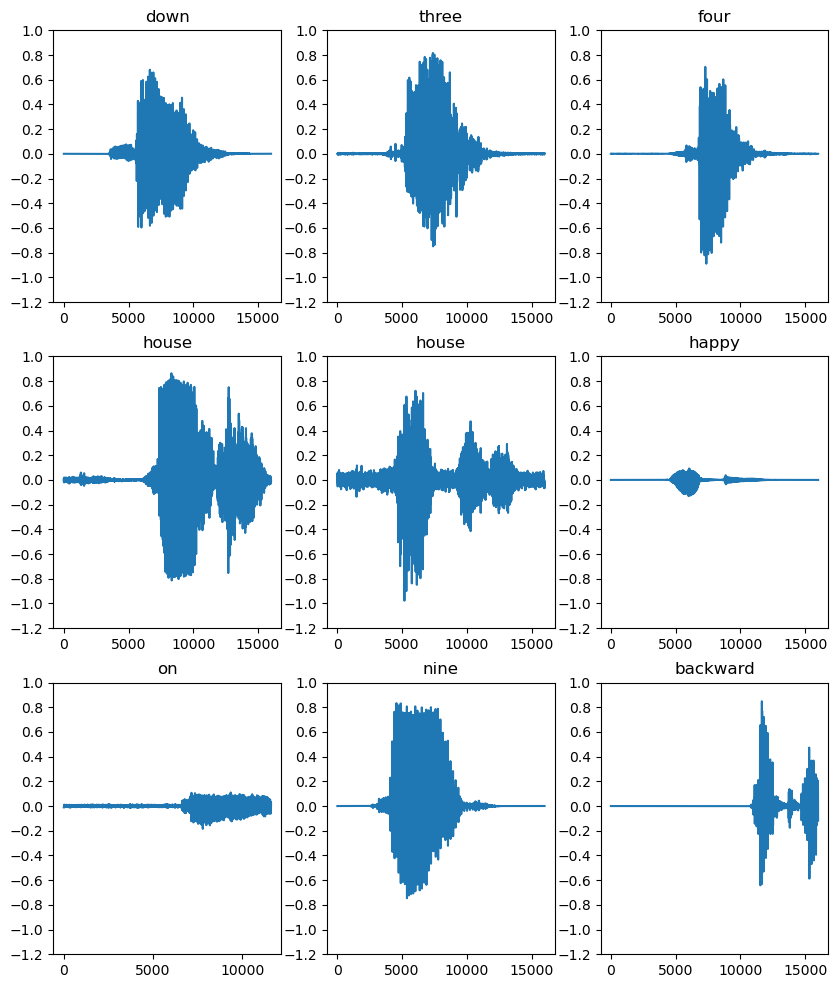

In [10]:
visual.plot_waveform_example()

In [11]:
visual.listen_waveform(save=True)

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


2023-05-23 22:59:02.520202: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


In [16]:
a,b = train_spectrograms.take(1)

2023-05-23 23:05:26.852177: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-05-23 23:05:26.852582: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-05-23 23:05:27.072659: I tensorflow/core/common_runtime/executor.cc:1210] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [71,201], In[1]: [400,40]
	 [

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Matrix size-incompatible: In[0]: [98,201], In[1]: [400,40]
	 [[{{node MatMul}}]] [Op:IteratorGetNext] name: 

2023-05-23 22:59:04.424478: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-05-23 22:59:04.424842: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-05-23 22:59:04.635993: I tensorflow/core/common_runtime/executor.cc:1210] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [71,201], In[1]: [400,40]
	 [

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Matrix size-incompatible: In[0]: [98,201], In[1]: [400,40]
	 [[{{node MatMul}}]] [Op:IteratorGetNext] name: 

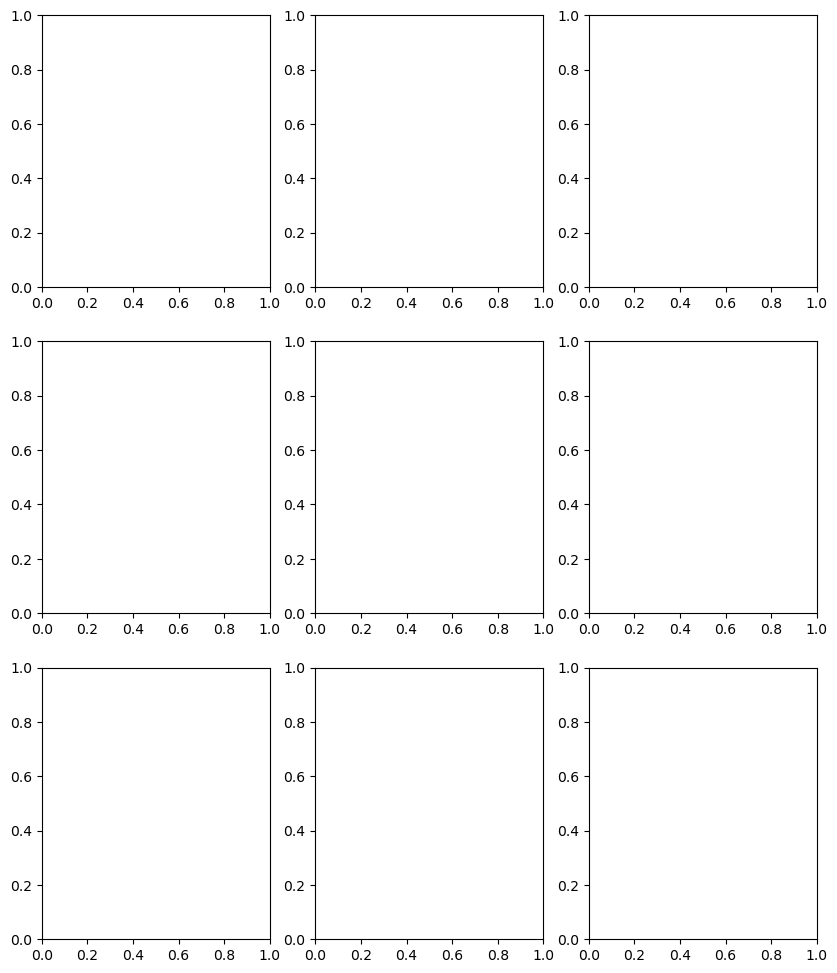

In [12]:
visual.plot_spectrogram_example()

In [13]:
files_ds = tf.data.Dataset.from_tensor_slices(train_files)

In [14]:
files_ds

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [4]:
data.get_data()
data.print_example()

Number of total examples: 105829
Number of examples per label: 4044
Example file tensor: tf.Tensor(b'DATA/speech_commands_v0.02/six/b69fe0e2_nohash_2.wav', shape=(), dtype=string)


2023-05-18 22:54:33.074187: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-18 22:54:33.074655: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-18 22:54:33.074686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aidin-HP-Laptop-15-bs1xx): /proc/driver/nvidia/version does not exist
2023-05-18 22:54:33.076095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
data.train_test_split()
data.print_split()

Training set size 84668
Validation set size 15877
Test set size 5291


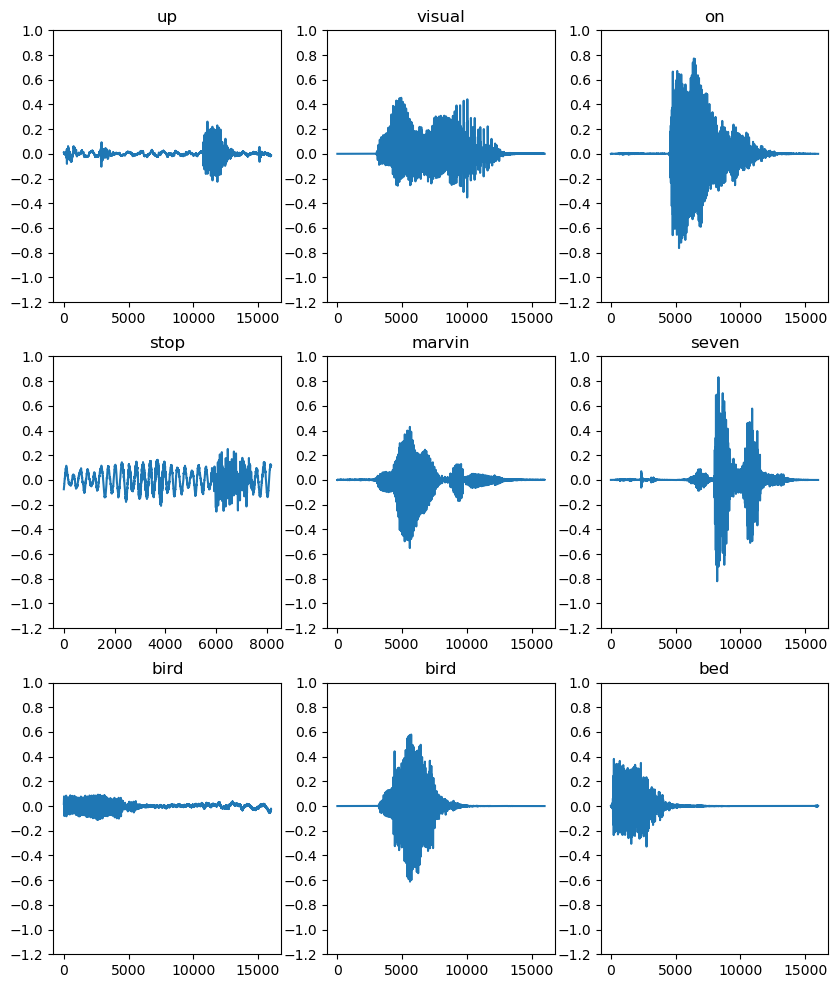

In [5]:
data.get_waveform_ds()
data.plot_waveform_example()

In [6]:
data.listen_waveform()

Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)


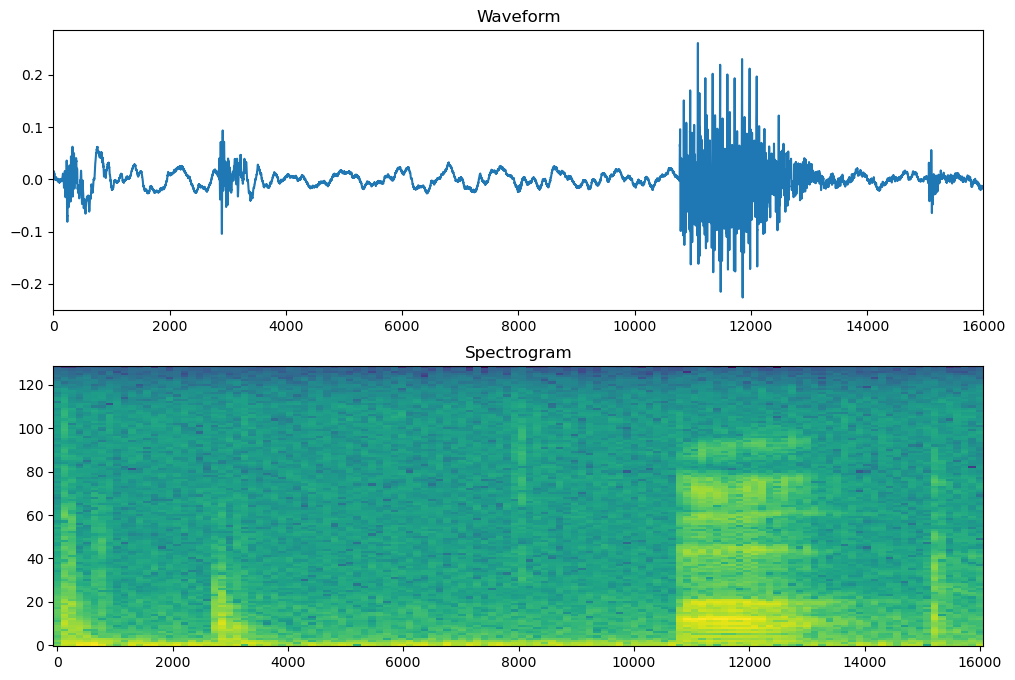

In [7]:
data.plot_spect()

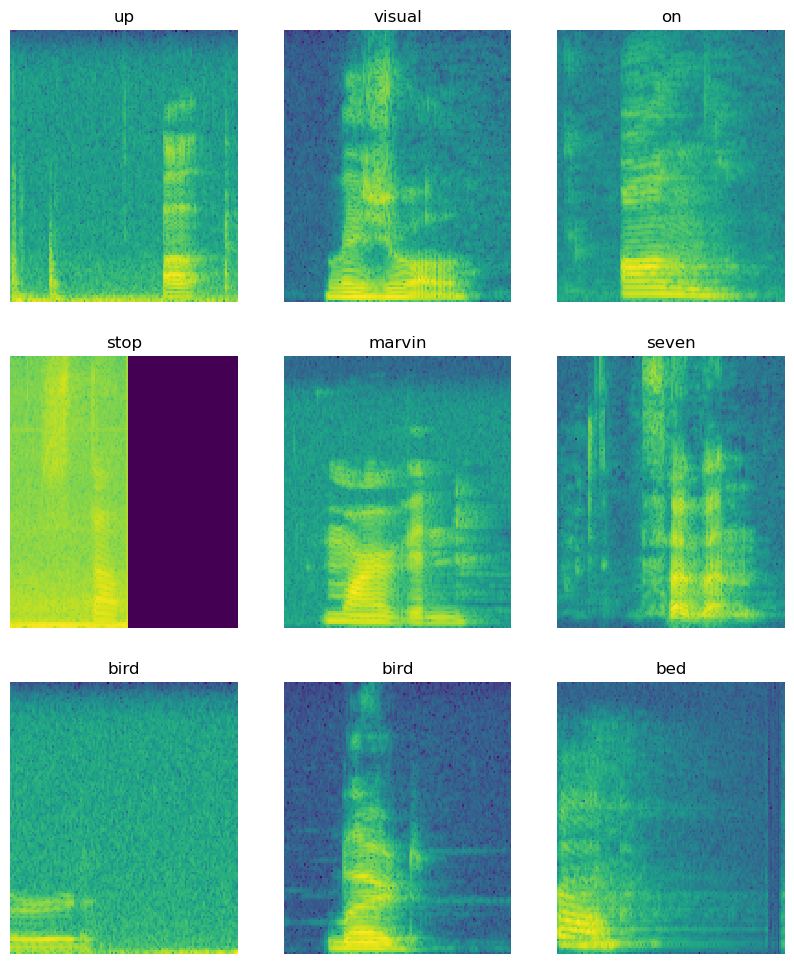

In [8]:
data.get_spectrogram_ds()
data.plot_spectrogram_example()

In [9]:
data.define_ds()
data.batch_ds()


In [13]:
model = cnn_one_tstride8(inputs=data, loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
model.print_input_shape()

Input shape: (124, 129, 1)
Output shape: 35


In [15]:
model.define_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 124, 129, 1)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 32, 126)        16254     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 10, 126)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 10, 78)         196638    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 10, 78)        0         
 2D)                                                       